# Exercise 2 - Language Translation with Word Level seq2seq DL Models
The objective is to convert a German sentence (sequence of words) to English using a Neural Machine Translation (NMT) system based on word level encoder-decoder models.

We will use __Spanish-English__ sentence pairs data from http://www.manythings.org/anki/

Sequence-to-Sequence (seq2seq) models are used for a variety of NLP tasks, such as text summarization, speech recognition, language translation, text-to-speech, speech-to-text among others. Our aim is to translate german to english sentences.

Here, both, the input and output are sentences. In other words, these sentences are a sequence of words going in and out of our model.

<img src="https://i.imgur.com/Uk1tCPo.png">

A typical seq2seq model is also known as an encoder-decoder model and has 2 major components:

+ The encoder
+ The decoder

Both these parts are essentially two different sequential models like RNNs\LSTMs which are combined together.

<img src="https://i.imgur.com/bT6PAtv.png">

## Download the Dataset

In [ ]:
!wget http://www.manythings.org/anki/spa-eng.zip
!unzip spa-eng.zip
!ls -l

--2021-03-17 16:35:59--  http://www.manythings.org/anki/spa-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.21.55.222, 172.67.173.198, 2606:4700:3036::ac43:adc6, ...
Connecting to www.manythings.org (www.manythings.org)|104.21.55.222|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4934182 (4.7M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   4.71M  3.60MB/s    in 1.3s    

2021-03-17 16:36:01 (3.60 MB/s) - ‘spa-eng.zip’ saved [4934182/4934182]

Archive:  spa-eng.zip
  inflating: _about.txt              
  inflating: spa.txt                 
total 23472
-rw-r--r-- 1 root root     1441 Jan 24 02:56 _about.txt
drwxr-xr-x 1 root root     4096 Mar  5 14:37 sample_data
-rw-r--r-- 1 root root  4934182 Jan 23 17:56 spa-eng.zip
-rw-r--r-- 1 root root 19088939 Jan 24 02:56 spa.txt


## Load the Dataset

In [ ]:
import numpy as np

FILE_NAME = './spa.txt'
with open(FILE_NAME, mode='rt', encoding='utf-8') as infile:
  data = infile.read()
  sentences = data.strip().split('\n')
  sentences = [item.split('\t') for item in sentences]
  eng_spa = np.array(sentences)

eng_spa = eng_spa[:50000]
eng_spa

array([['Go.', 'Ve.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['Go.', 'Vete.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['Go.', 'Vaya.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['Please turn off the radio.', 'Por favor, apague la radio.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1197303 (waeltken) & #1198501 (cueyayotl)'],
       ['Please turn off the radio.', 'Apagá la radio, por favor.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1197303 (waeltken) & #1215556 (El_mas_capo)'],
       ['Please wake me up at 6:30.',
        'Por favor despiértame a las seis y media.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2429736 (CK) & #2429789 (kuma)']],
      dtype='<U278')

In [ ]:
spa = eng_spa[:,1]
eng = eng_spa[:,0]
eng, spa

(array(['Go.', 'Go.', 'Go.', ..., 'Please turn off the radio.',
        'Please turn off the radio.', 'Please wake me up at 6:30.'],
       dtype='<U278'),
 array(['Ve.', 'Vete.', 'Vaya.', ..., 'Por favor, apague la radio.',
        'Apagá la radio, por favor.',
        'Por favor despiértame a las seis y media.'], dtype='<U278'))

## Basic Preprocessing

In [ ]:
import string

# Remove punctuation and lowercase
eng = np.array([s.translate(str.maketrans('', '', string.punctuation)).lower() for s in eng])
spa = np.array([s.translate(str.maketrans('', '', string.punctuation)).lower() for s in spa])
eng, spa

(array(['go', 'go', 'go', ..., 'please turn off the radio',
        'please turn off the radio', 'please wake me up at 630'],
       dtype='<U25'),
 array(['ve', 'vete', 'vaya', ..., 'por favor apague la radio',
        'apagá la radio por favor',
        'por favor despiértame a las seis y media'], dtype='<U74'))

## Analyze Sentences

### **Question 1**: Get maximum sentence length for both __English__ and __Spanish__


In [ ]:
eng_len = [len(s.split()) for s in eng]
spa_len = [len(s.split()) for s in spa]

max(eng_len), max(spa_len)

(8, 15)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9f082e4490>,
      dtype=object)

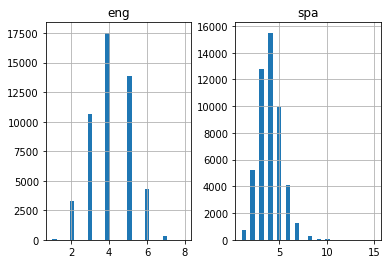

In [ ]:
import pandas as pd
%matplotlib inline

length_df = pd.DataFrame({'eng':eng_len, 'spa':spa_len})
length_df.hist(bins=30)

## Transform Text to Sequence of Numbers

### **Question 2**: Use **``tensorflow.keras.tokenizer``** to tokenize and prepare a text to number mapping


In [ ]:
from tensorflow import keras

eng_tokenizer = keras.preprocessing.text.Tokenizer()
eng_tokenizer.fit_on_texts(eng)
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max(eng_len)

In [ ]:
print('Max eng text length:', eng_length)
print('English Vocabulary Size:', eng_vocab_size)

Max eng text length: 8
English Vocabulary Size: 6861


In [ ]:
spa_tokenizer = keras.preprocessing.text.Tokenizer()
spa_tokenizer.fit_on_texts(spa)
spa_vocab_size = len(spa_tokenizer.word_index) + 1
spa_length = max(spa_len)

In [ ]:
print('Max deu text length:', spa_length)
print('Spanish Vocabulary Size:', spa_vocab_size)

Max deu text length: 15
Spanish Vocabulary Size: 14058


## Prepare Train Test Splits

In [ ]:
from sklearn.model_selection import train_test_split

train_spa, test_spa, train_eng, test_eng = train_test_split(spa, eng, test_size=0.2, random_state = 42)
train_spa.shape, test_spa.shape, train_eng.shape, test_eng.shape

((40000,), (10000,), (40000,), (10000,))

In [ ]:
train_spa_enc = spa_tokenizer.texts_to_sequences(train_spa)
train_spa_enc = keras.preprocessing.sequence.pad_sequences(train_spa_enc, maxlen=spa_length, padding='post')

train_eng_enc = eng_tokenizer.texts_to_sequences(train_eng)
train_eng_enc = keras.preprocessing.sequence.pad_sequences(train_eng_enc, maxlen=eng_length, padding='post')

train_spa_enc.shape, train_eng_enc.shape

((40000, 15), (40000, 8))

## Normalize Sequence Lengths
We normalize sentence lengths by defining the maximum length. Larger sentences/sequences get truncated while smaller ones are padded.

### **Question 3**: Normalize sentences by defining the max length. **Pad** shorter ones and truncate the longer ones.

_Hint: use ``pad_sequences``_


In [ ]:
test_spa_enc = spa_tokenizer.texts_to_sequences(test_spa)
test_spa_enc = keras.preprocessing.sequence.pad_sequences(test_spa_enc, maxlen=spa_length, padding='post')

test_eng_enc = eng_tokenizer.texts_to_sequences(test_eng)
test_eng_enc = keras.preprocessing.sequence.pad_sequences(test_eng_enc, maxlen=eng_length, padding='post')

test_spa_enc.shape, test_eng_enc.shape

((10000, 15), (10000, 8))

## Build the Model

<img src="https://i.imgur.com/3ZVi97s.png">

+ For the encoder, we will use an embedding layer and an LSTM layer
+ For the decoder, we will use another LSTM layer followed by a dense layer
+ Repeat Vector helps pass the output sequence from encoder to all LSTM cells in the decoder

We leverage the full power of GPUs by using the CUDA variant of the LSTM models.

### **Question 4**: Define a **Seq2Seq** model with encoder and decoder components

In [ ]:
EMBEDDING_DIM = 512
LSTM_UNITS = 512

encoder_inputs = keras.layers.Input(shape=(spa_length,))
enc_emb =  keras.layers.Embedding(spa_vocab_size, EMBEDDING_DIM)(encoder_inputs)
encoder_lstm = keras.layers.LSTM(LSTM_UNITS)(enc_emb)
rp_vec = keras.layers.RepeatVector(eng_length)(encoder_lstm)

decoder_lstm = keras.layers.LSTM(LSTM_UNITS, return_sequences=True)(rp_vec)
decoder_softmax = keras.layers.Dense(eng_vocab_size, activation='softmax')(decoder_lstm)
model = keras.models.Model(inputs=encoder_inputs, outputs=decoder_softmax)

model.compile(optimizer=keras.optimizers.RMSprop(lr=0.001), loss='sparse_categorical_crossentropy')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 512)           7197696   
_________________________________________________________________
lstm (LSTM)                  (None, 512)               2099200   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 8, 512)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8, 512)            2099200   
_________________________________________________________________
dense (Dense)                (None, 8, 6861)           3519693   
Total params: 14,915,789
Trainable params: 14,915,789
Non-trainable params: 0
_________________________________________________

## Train the Model

In [ ]:
history = model.fit(train_spa_enc, train_eng_enc.reshape(train_eng_enc.shape[0], train_eng_enc.shape[1], 1), 
          epochs=50, batch_size=256, 
          validation_split = 0.1,
          verbose=1)

Epoch 1/50
141/141 [==============================] - 48s 112ms/step - loss: 3.9368 - val_loss: 3.2075
Epoch 2/50
141/141 [==============================] - 14s 103ms/step - loss: 3.1686 - val_loss: 3.0191
Epoch 3/50
141/141 [==============================] - 15s 103ms/step - loss: 2.9437 - val_loss: 2.8130
Epoch 4/50
141/141 [==============================] - 14s 102ms/step - loss: 2.7050 - val_loss: 2.6606
Epoch 5/50
141/141 [==============================] - 15s 104ms/step - loss: 2.5313 - val_loss: 2.5198
Epoch 6/50
141/141 [==============================] - 15s 105ms/step - loss: 2.3409 - val_loss: 2.3972
Epoch 7/50
141/141 [==============================] - 15s 104ms/step - loss: 2.1678 - val_loss: 2.2847
Epoch 8/50
141/141 [==============================] - 15s 104ms/step - loss: 2.0141 - val_loss: 2.1829
Epoch 9/50
141/141 [==============================] - 15s 103ms/step - loss: 1.8798 - val_loss: 2.1142
Epoch 10/50
141/141 [==============================] - 15s 103ms/step - l

In [ ]:
model.save('my_nmt_model.h5')

## Visualize Training Progress

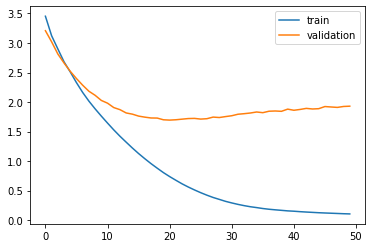

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])

## Text Generator
We build a utility function to generate text sequences based on the output prediction sequences

In [ ]:
from tqdm import tqdm
pd.set_option('display.max_colwidth', 500)

eng_idx2word = {v:k for k, v in eng_tokenizer.word_index.items()}

def generate_prediction_texts(pred_seqs, idx2word_map):
  pred_texts = []

  for pred in tqdm(preds):
    temp = []
    for idx in range(len(pred)):
      w = eng_idx2word.get(pred[idx], None)
      if idx > 0:
        if (w == eng_idx2word.get(pred[idx-1], None)) or (w == None):
            temp.append('')
        else:
            temp.append(w)
          
      else:
        if(w == None):
            temp.append('')
        else:
            temp.append(w)            
        
    pred_texts.append(' '.join(temp))
  return pred_texts

## Translation using seed from Training Data

In [ ]:
train_spa_enc[:1000,:].shape

(1000, 15)

### **Question 5**: **Evaluate** model predictions using training samples only


In [ ]:
pred_probs = model.predict(train_spa_enc[:1000,:].reshape((train_spa_enc[:1000,:].shape[0], 
                                                           train_spa_enc[:1000,:].shape[1])), verbose=1)
preds = [np.argmax(i, axis=1) for i in pred_probs]
# convert predictions into text (English)
pred_texts = generate_prediction_texts(pred_seqs=preds, idx2word_map=eng_idx2word)
pred_df = pd.DataFrame({'source': train_spa[:1000], 'target' : train_eng[:1000], 'predicted' : pred_texts})

32/32 [==============================] - 1s 15ms/step


100%|██████████| 1000/1000 [00:00<00:00, 80537.34it/s]


In [ ]:
pred_df.head(50).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
source,él se casó con una azafata,le conté todo,quizá deberías preguntarle a tom,tom menosprecia a mary,estamos completamente despiertos,¿cuál es tu tipo,ellos estaban satisfechos,ella está haciendo un dibujo,su historia suena cierta,esto parece demasiado fácil,soy guardés,vive en su coche,¿ves una estrella,¿no estabas de salida,yo los conozco personalmente,yo uso twitter,bajó a desayunar,por favor mantenme informado,¿de cuánto estás embarazada,es un problema,ahora déjanos,¿puedo ir al baño,no salgas sin sombrero,tom estaba curioso,esto está riquísimo,eres genial,preferiría que no,quiero un dólar,hemos perdido el contacto,¿te gustan los robots,he olvidado su nombre,he ganado el primer premio,tengo algo para tom,vete,quiero un trozo de tarta,solía jugar al tenis,quieren esto,sois pequeñas,tom recordará,¡hola tom,tom usa ropa sencilla,lo haré por vosotros,estaré con tom,haz una oferta,sos demasiado modesto,no soy tu niñera,venimos de inmediato,vuelve dentro de un mes,fui engañado por él,no eres la única
target,he married a stewardess,i told him everything,maybe you should ask tom,tom despises mary,were wide awake,whats your type,they were satisfied,she is drawing a picture,his story sounds true,this seems too easy,im housesitting,he lives in his car,do you see a star,werent you leaving,i know them personally,im using twitter,he came down to breakfast,please keep me updated,how far along are you,its a problem,now leave us,may i go to the toilet,dont go without a hat,tom was curious,this is delicious,youre great,id rather not,i want a dollar,weve lost contact,do you like robots,i forget his name,ive won first prize,i have something for tom,go,i want a piece of cake,i used to play tennis,they want this,youre small,tomll remember,hello tom,tom wears simple clothes,ill do that for you,ill be with tom,make an offer,youre too modest,im not your nanny,were coming at once,come back within a month,he cheated on me,youre not the only one
predicted,he married a stewardess,i told him everything,maybe you should ask tom,tom despises mary,were wide awake,whats your type,they were satisfied,she is drawing a picture,his story sounds true,this seems too easy,im housesitting,he lives in his car,do you see a star,werent you leaving,i know them personally,im using twitter,he came down to breakfast,please keep me updated,how far along are you,its a problem,now leave us,may i go to the bathroom,dont go without a hat,tom was curious,this is delicious,youre great,id rather not,i want a dollar,weve lost contact,do you like robots,i forget his name,ive won first prize,i have something for tom,go,i want a piece of cake,i used to play tennis,they want this,youre small,tomll remember,hi tom,tom wears clothes,ill do that for you,ill be with tom,make an offer,youre too modest,im not your nanny,were coming at once,come back within a month,i was on by him,youre not the only one


## Translation on Test Data

### **Question *6*: **Evaluate** model performance on test data


In [ ]:
pred_probs = model.predict(test_spa_enc[:1000,:].reshape((test_spa_enc[:1000,:].shape[0],
                                                          test_spa_enc[:1000,:].shape[1])), verbose=1)
preds = [np.argmax(i, axis=1) for i in pred_probs]
# convert predictions into text (English)
pred_texts = generate_prediction_texts(pred_seqs=preds, idx2word_map=eng_idx2word)
pred_df = pd.DataFrame({'source': test_spa[:1000], 'target' : test_eng[:1000], 'predicted' : pred_texts})

32/32 [==============================] - 0s 14ms/step


100%|██████████| 1000/1000 [00:00<00:00, 104941.55it/s]


In [ ]:
pred_df.head(50).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
source,debes dar lo mejor,¿está tom farfullando,me helé,sigue hacia la izquierda,no entiendo eso,verdaderamente eres un caso perdido,tú estás farfullando,¿el mercurio es verdaderamente un metal,te ves gordo,están tratando de ayudar,haz lo que yo digo no lo que yo hago,¿sabés la dirección,eres mi hijo,es mi cd,yo hice una muñeca a mary,me has decepcionado tom,quería luchar,él tiene once hijos,no hay nada erróneo,siempre estoy feliz,se equivocan,ella la aterrorizaba,déjelo a tomás,tengo una opinión diferente,tom fue torturado,ahora vivo en boston,la estrategia de tom surtió efecto,él es más inteligente que ella,tom no planea ir,volveremos por la noche,usa toneladas de maquillaje,tom depende de mary,a ella le gusta él,tom dijo que sí,¿ellos también vienen,eres inteligente,déjame pensar un minuto,¡qué lindo auto,tráeme un trozo de tiza,ven a casa a las seis,ellos están esperando afuera,me da tristeza escucharlo,estoy resfriado,¿qué quieres que haga,¿cuántos años tiene vuestro tío,el capitán nos dio la bienvenida,detén el ascensor,tengo dolor de estómago,esta carta es para mí,¿tom parecía feliz
target,you must do your best,is tom babbling,i froze,keep to the left,i dont understand that,you really are hopeless,youre babbling,is mercury really a metal,you look fat,theyre trying to help,do as i say not as i do,do you know the address,youre my son,its my cd,i made mary a doll,you let me down tom,i wanted to fight,he has eleven children,nothing is wrong,im always happy,you are wrong,she terrified her,leave tom,i think otherwise,tom was tortured,i live in boston now,toms strategy paid off,hes smarter than her,tom has no plans to go,well be back tonight,she wears heavy makeup,tom depends on mary,she loves him,tom said yes,are they coming as well,youre intelligent,let me think for a minute,what a nice looking car,bring me a piece of chalk,come home at six,theyre waiting outside,i am sad to hear it,ive got a cold,you want me to do what,how old is your uncle,the captain welcomed us,hold the elevator,i have a stomachache,this letters for me,did tom seem happy
predicted,you must do best,is tom happening,i got myself,keep out the from,i dont do that,you really me,youre lied,is that a or,you look fat,theyre want to help,do i do it,do see the,youre my son,this is my cd,i made a broken with tom,ive became youve,i wanted to,he has a children,theres nothing,im always happy,they gone,she went in,leave tom,i have an terrible,tom was arrogant,im going boston,toms tom toms from,hes smarter than them,tom didnt want to go,she come all night,use it move,tom is on to me,she likes him,tom said yes,are they coming too,youre clever,let me think for a minute,how a boy,give me a piece of chalk,come home at six,theyre are waiting,i dont feel i dont it,i am pretty,what do you want to do,how old is your uncle,he came for,keep out the point,i have full,this song is for me,has tom have


In [ ]:
pred_df.iloc[500:550].T

,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549
source,quítese los calcetines,tom no es nunca puntual,él es demasiado viejo,estoy haciendo huevos revueltos,ellos nos ayudan,comeré aquí,todos ustedes son diligentes,me gusta teñirme el pelo,tom lleva la delantera,el dinero es malísimo,veo mi barco,no te quiero aquí,necesito un sobre,¿de quién es este portátil,tom está andando en una bicicleta,tom está cavando un agujero,tom ha encontrado a mary,me siento bastante aturdido,somos de segundo,no seas duro con tom,¿tom cenó,¿os gusta nadar,estudió para ser doctor,tengo un montón por hacer,se odiaban,soy adicta,luces fabulosa,nosotros somos humanos,sé que es un desastre,¿se han marchado,quiero advertirte,¡cogedlo,¿puedo comer algo,¿habla inglés,rompe en llanto,tom le subió el volumen al televisor,disculpe la tardanza,lamento llegar tarde,la mitad de ésos son míos,le pedí a tom que condujese,él se escapó,me sentía incluso más pequeño,te lo contaré mañana,los perros pueden ver en la oscuridad,los precios son elevados,¿podéis ir más rápido,¿puedes cantar esta canción,se ha graduado de harvard,por favor tómate algo,soy estudiante
target,take off your socks,tom is never on time,hes too old,im making scrambled eggs,they help us,ill eat here,you are all diligent,i like to dye my hair,tom is in the lead,the money is terrible,i see my ship,i dont want you here,i need an envelope,whose is that notebook,tom is riding a bicycle,tom is digging a hole,tom has found mary,i feel pretty groggy,were sophomores,dont be hard on tom,did tom eat dinner,do you like swimming,he studied to be a doctor,i have a great deal to do,they hated themselves,im an addict,you look fabulous,were humans,i know its a mess,are they gone,i want to warn you,seize him,may i eat something,does he speak english,hes beginning to cry,tom turned up the tv,im sorry im late,excuse me for being late,half of these are mine,i asked tom to drive,he got away,i felt even smaller,i will tell you tomorrow,dogs can see in the dark,the prices are high,can you go faster,can you sing this song,he graduated from harvard,please have a drink,i am a student
predicted,take off your socks,tom isnt die,he is too old,im am three eggs,they help us,ill eat here,all are them,i like the hair,tom is out the is,money is important,i see my new,i dont want you here,i need an stand,whose letter is this from,tom is like a bicycle,tom is on a child,tom found mary,i feel awful sometimes,were in stay,dont be hard with tom,does tom enjoy yet,do you like swimming,he found it a,i have a lot to do,they stood lying,i am taller,i get the do,were canadians,i know thats a clever,are they gone,i want to believe you,well it,can i eat some,do you speak english,think meet yourself,tom left the house,sorry to be late,im sorry for being late,those these are,i asked tom to leave,he is up,i felt even smaller,ill show you there,the can you the,prices are delicious,can you go faster,can you stop this song,he has gone a death,please do something,im am student
